In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%run -i ../Respaldo_Codigos_desarrollado/Kalman/iono_models.py
%run -i ../Respaldo_Codigos_desarrollado/Kalman/kalman.py
%run -i ../Respaldo_Codigos_desarrollado/Kalman/kalman_coop.py
%run ../code/multirover4.py

from scipy.optimize import minimize,fsolve, basinhopping

In [5]:
dia1 = "010"
dian = "013"
ano = "2017"

Observable = "C1"
# Variables de la grafica
error_max = 100

# Ubicacion de la Rinex local DB 
Rinex_dataBase      = "../../0_bitbucket/new_data"
Simu_Folder         = getcwd() +"/" + "Temp_Simul_data"

# agregando nuevos pares de estaciones (que no estan en el kmz)
#parejas_kmz        = get_data_stations("./Coconet_sites_2016.kmz", 1e3)
#parejas_kmz        = get_data_stations("./UNAVCO_perm.kmz", 300) # 110
parejas_kmz = {}

#parejas_kmz[0] = ("OLVN", "AIRS", "NWBL",)
#parejas_kmz[5] = ('BELE', 'BEPA',)

parejas_kmz[1] = ("BARA", "TGDR")#, "JME2",)
#parejas_kmz[2] = ("ljrn", "p553", "p554", "fzhs",)
parejas_kmz[3] = ("CN20", "TGPM",)
parejas_kmz[4] = ('TGMX', 'UNPM',)

info = {}
info[0] = "Monserrat (Antillas Caribeñas)"
info[1] = "Rep. Dominicana"
info[2] = "USA"
info[3] = "Panáma"
info[4] = "México"

RinexDB = descarga_Rinex_Compri(Rinex_dataBase, parejas_kmz, dia1, dian, ano)
## Leer los rinex almacenado en mi equipo
RinexDB = read_Rinex_Compri(Rinex_dataBase, parejas_kmz)

#pareja = parejas_kmz[3]
resolucion = 1000
tsample_sample = 15

axis_labels = ["gps_sow ["+str(resolucion*tsample_sample)+" s]", "error [m]", "stdlone_err vs coop_err"]


ion_mas= [None, "dual_freq", "dual_freq", "klobu", "dual_freq", "standard", "dual_freq", "taylor"]
ion_rov= [None,  None,       "klobu",     "klobu",  "standard",   "standard", "taylor" ,   "taylor"]

distances=[0., 5, 10]

N_shemes_start = 0
N_shemes_end   = 7
show_plots_nb = True   # For development
show_plots_doc = True # For generate reports


 Descargando Nuevos Archivos ....
************************

	 [Estacion] 	 [dia GPS] 		 [RESULTADO]
	 bara
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos ya disponibles!!!
			 013 		 Archivos ya disponibles!!!
	 tgdr
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos ya disponibles!!!
			 013 		 Archivos ya disponibles!!!
	 cn20
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos ya disponibles!!!
			 013 		 Archivos ya disponibles!!!
	 tgpm
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos ya disponibles!!!
			 013 		 Archivos ya disponibles!!!
	 tgmx
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos ya disponibles!!!
			 013 		 Archivos ya disponibles!!!
	 unpm
			 010 		 Archivos ya disponibles!!!
			 011 		 Archivos ya disponibles!!!
			 012 		 Archivos y

In [6]:
scenarios = [["%s.%s" %(item, subitem) for subitem in range(1, len(distances)+1)] for item in range(1, 9)]
Ionos_master = [["%s" %(item) for subitem in range(1, len(distances)+1)] for item in ion_mas]
Ionos_rover  = [["%s" %(item) for subitem in range(1, len(distances)+1)] for item in ion_rov]

scenary = scenarios[N_shemes_start:N_shemes_end+1]
Ionos_m = Ionos_master[N_shemes_start:N_shemes_end+1]
Ionos_r = Ionos_rover[N_shemes_start:N_shemes_end+1]

df_res=pd.DataFrame()


for schemes, ionos_m, ionos_r in zip(scenary, Ionos_m, Ionos_r):
    #print (schemes)
    tit = []
    Resul_final, Scheme_tags = [], []
    
    for d, scheme, ion_master, ion_rover in zip(distances, schemes, ionos_m, ionos_r):
        print " \t ", scheme, ion_master, ion_rover, d
        
        # incrustar titulo de seccion\n"
        display(Latex(section_title(0, scenario=scheme).encode("utf-8")))

        print ("*"*35)
        print ("Start simulation for scheme ", scheme)
        print ("*"*35)
        
        R11, _ = simulation_multirover_coop2(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano,
                                            distances = d,
                                            Simu_Folder=None,
                                            res_plot=resolucion,
                                            iono_model_master= ion_master,
                                            iono_model_rover = ion_rover,
                                            silent_exec=False, wls=True, k_a=0.1)
        
        tit.append(scheme)
        #df_res = gen_df_results3(df_res, R11, scheme)
        df_res, df_res_full = get_df_res(df_res, R11, scheme)
        display(df_res)
        df13 = df_res[df_res['scenario'].isin(tit)]
        df13 = create_multi(df13,
                            index=['gps_day', 'stations', 'scenario'],
                            cols=["improve_by_agrupation", "improve_by_station"])
        display(df13)
        
        Tabla = df13.to_latex().encode('ascii','ignore')
        label = "tabla_"+scheme
        caption = "\'Indice de mejora para escenario %s"%(scheme)

        display(Table_latex(table=Tabla, ref=label, cap=caption))
        # incrustar titulo de seccion\n",
        display(Latex(section_title(1, scenario=scheme).encode("utf-8")))
        
        #"""
        plot_from_dict(R11, axis_labels=axis_labels, scenario=scheme, 
                       plot_inline=show_plots_nb,
                       plot_in_doc=False)
        
        #plotting_df3
        plotting_df_res(df_res, scheme,
            title="Improvement index: ",
            xlabel="gps_sow", #  ["+str(resolucion)+\"x30s]",
            ylabel="err_stdlone - err_coop [m]",
            plot_inline=show_plots_nb,
            plot_in_doc=show_plots_doc)
        #"""
        Resul_final.append(R11)
        Scheme_tags.append(scheme)
    
    csv_content = pd.DataFrame([Resul_final], columns=Scheme_tags)
    
    backup = pd.HDFStore('Analisis_weight_010'+str(tit)+'.h5')
    backup['Resul_final'] = csv_content
    backup['df_res'] = df_res
    backup.close()

 	  1.1 None None 0.0


<IPython.core.display.Latex object>

***********************************
('Start simulation for scheme ', '1.1')
***********************************
[GPS day]   [year]	[Station Pair]		[Process status]

 010	2017 	   ('BARA', 'TGDR')	WARNING! observation `C2` no present in file /home/zenbook/Escritorio/repo/Desarrollo_Actual/Temp_Simul_data/bara0100.17o
WARNING! observation `C2` no present in file /home/zenbook/Escritorio/repo/Desarrollo_Actual/Temp_Simul_data/tgdr0100.17o
 Running...  
st [39.801149846032452, 14.42516476660022]
cp [44.03166586011784, 29.300096808804906] diff [ -4.23051601 -14.87493204]

st [44.999950749694342, 16.132699384833938]
cp [43.693532859724804, 18.378125544925343] diff [ 1.30641789 -2.24542616]

st [39.434150179294022, 17.974103191034018]
cp [39.678658930259708, 22.270988199549858] diff [-0.24450875 -4.29688501]

st [42.657872576361022, 16.405674763546255]
cp [42.307311065802985, 17.370305501469208] diff [ 0.35056151 -0.96463074]

st [41.396625765971763, 16.790326457674578]
cp [53.234606367879671

KeyboardInterrupt: 

In [22]:
%matplotlib inline
import numpy as np

def rlse_online(aT_k1,b_k1,x,P): 
    K = np.dot(P,aT_k1.T)/(np.dot(np.dot(aT_k1,P),aT_k1.T)+1)
    x = x +K*(b_k1-np.dot(aT_k1,x))
    P = P-np.dot(K,np.dot(aT_k1,P))
    return x,K,P

n = 2
vals = np.array([[3.0,4.0,6.0,3.0,8.0,7.0,5.0]]).T
P = np.eye(n,n)*100.
x = np.zeros((n,1))
vals, x

(array([[ 3.],
        [ 4.],
        [ 6.],
        [ 3.],
        [ 8.],
        [ 7.],
        [ 5.]]), array([[ 0.],
        [ 0.]]))

[[0 1]] [ 3.]
[[1 1]] [ 4.]
[[2 1]] [ 6.]
[[3 1]] [ 3.]
[[4 1]] [ 8.]
[[5 1]] [ 7.]
[[6 1]] [ 5.]
[[ 0.5037057 ]
 [ 3.62655923]]


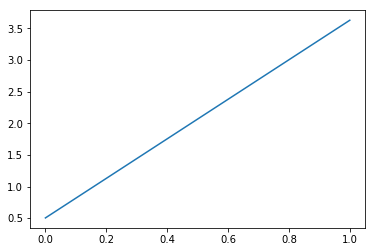

In [23]:
for k in range(len(vals)):
    print np.array([[k,1]]), vals[k,:]
    x,K,P = rlse_online(np.array([[k,1]]),vals[k,:],x,P)
print x
plt.plot(x)

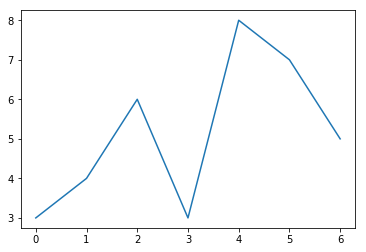

In [19]:
x = [x for x in range(0,7)]
plt.plot(x,vals)